This tutorial demonstrates some common usage patterns for *The Joker* with more description and pedagogy than other tutorials in the documentation. This is therefore a good starting point for new users of *The Joker*.

# Getting started with The Joker

*The Joker* (pronounced Yo-kurr) is a highly specialized Monte Carlo (MC) sampler that is designed to generate converged posterior samplings for Keplerian orbital parameters, even when your data are sparse, non-uniform, or very noisy. This is *not* a general MC sampler, and this is *not* a Markov Chain MC sampler like `emcee`, or `pymc3`: This is fundamentally a [rejection sampler](https://en.wikipedia.org/wiki/Rejection_sampling) with some tricks that help improve performance for the two-body problem.

*The Joker* shines over more conventional MCMC sampling methods when your radial velocity data is imprecise, non-uniform, sparse, or has a short baseline: In these cases, your likelihood function will have many, approximately equal-height modes that are often spaced widely, all properties that make conventional MCMC bork when applied to this problem. In this tutorial, we will not go through the math behind the sampler (most of that is covered [in the original paper](https://arxiv.org/abs/1610.07602)). However, some terminology is important to know for the tutorial below or for reading the documentation. Most relevant, the parameters in the two-body problem (Kepler orbital parameters) split into two sets: nonlinear and linear parameters. The nonlinear parameters are always the same in each run of The Joker: period $P$, eccentricity $e$, argument of pericenter $\omega$, and a phase $M_0$. The default linear parameters are the velocity semi-ampltude $K$, and a systemtic velocity $v_0$. However, there are ways to add additional linear parameters into the model (as described in other tutorials).

For this tutorial, we will set up an inference problem that is common to binary star or exoplanet studies, show how to generate posterior orbit samples from the data, and then demonstrate how to visualize the samples. Other tutorials demonstrate more advanced or specialized functionality included in *The Joker*, like:
- fully customizing the parameter prior distributions,
- continuing sampling with standard MCMC methods when *The Joker* returns one or few samples,
- allowing for a long-term velocity trend in the data, 
- simultaneously inferring constant offsets between data sources (i.e. when using data from multiple instruments that may have calibration offsets)

But let's start here with the most basic functionality!

First, imports we will need later:

In [74]:
import astropy.table as at
from astropy.time import Time
import astropy.units as u
from astropy.visualization.units import quantity_support
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from thejoker import RVData, JokerPrior, TheJoker, JokerSamples
from thejoker.plot import plot_rv_curves

## Loading radial velocity data

To start, we need some radial velocity data to play with. Our ultimate goal is to construct or read in a `thejoker.RVData` instance, which is the main data container object used in *The Joker*. For this tutorial, we will use a simulated RV curve that was generated using a separate script and saved to a CSV file, and we will create an `RVData` instance manually. 

Because we previously saved this data as an Astropy [ECSV](http://docs.astropy.org/en/latest/api/astropy.io.ascii.Ecsv.html#astropy.io.ascii.Ecsv) file, the units are provided with the column data and read in automatically using the [astropy.table read/write interface](http://docs.astropy.org/en/latest/table/index.html):

In [2]:
data_tbl = at.QTable.read('data.ecsv')
data_tbl[:2]

bjd,rv,rv_err
,km / s,km / s
float64,float64,float64
2458500.2394509446,-30.438727324834776,1.487315452607967
2458500.3083098205,-30.33258932639268,2.7224203521088195


The full simulated data table has many rows (256), so let's randomly grab 4 rows to work with:

In [13]:
rnd = np.random.RandomState(seed=42)
sub_tbl = data_tbl[rnd.choice(len(data_tbl), size=4, replace=False)]

In [14]:
sub_tbl

bjd,rv,rv_err
,km / s,km / s
float64,float64,float64
2458633.6342277676,-44.77678390286918,0.6184936400942356
2458502.5604345095,-27.22753293212991,0.4237804477659354
2458542.0719575016,-42.731114045315735,0.590251001840618
2458620.35411061,-31.85638942078276,0.42817499540061543


It looks like the time column is given in Barycentric Julian Date (BJD), so in order to create an `RVData` instance, we will need to create an `astropy.time.Time` object from this column:

In [15]:
t = Time(sub_tbl['bjd'], format='jd', scale='tcb') 
data = RVData(t=t, rv=sub_tbl['rv'], rv_err=sub_tbl['rv_err'])

We now have an `RVData` object, so we could continue on with the tutorial. But as a quick aside, there is an alternate, more automatic (automagical?) way to create an `RVData` instance from tabular data: `RVData.guess_from_table`. This classmethod attempts to guess the time format and radial velocity column names from the columns in the data table. It is very much an experimental feature, so if you think it can be improved, please open an issue in the [GitHub repo for The Joker](https://github.com/adrn/thejoker/issues). In any case, here it successfully works:

In [16]:
data = RVData.guess_from_table(sub_tbl)

One of the handy features of `RVData` is the `.plot()` method, which generates a quick view of the data:

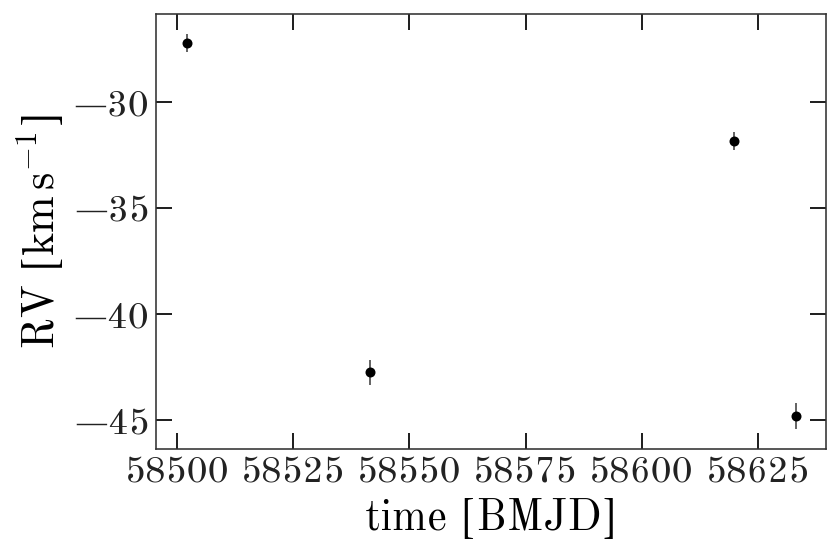

In [17]:
_ = data.plot()

The data are clearly variable! But what orbits are consistent with these data? I suspect many, given how sparse they are! Now that we have the data in hand, we need to set up the sampler by specifying prior distributions over the parameters in *The Joker*.

## Specifying the prior distributions for The Joker parameters

The prior *pdf* (probability distribution function) for *The Joker* is controlled and managed through the `thejoker.JokerPrior` class. The prior for *The Joker* is fairly customizable and the initializer for `JokerPrior` is therefore pretty flexible; usually too flexible for typical use cases. We will therefore start by using an alternate initializer defined on the class, `JokerPrior.default()`, that provides a simpler interface for creating a `JokerPrior` instance that uses the default prior distributions assumed in *The Joker*. In the default prior:
$$
\begin{align}
&p(P) \propto \frac{1}{P} \quad ; \quad P \in (P_{\rm min}, P_{\rm max})\\
&p(e) = B(a_e, b_e)\\
&p(\omega) = \mathcal{U}(0, 2\pi)\\
&p(M_0) = \mathcal{U}(0, 2\pi)\\
&p(K) = \mathcal{N}(K \,|\, \mu_K, \sigma_K)\\
&\sigma_K = \sigma_{K, 0} \, \left(\frac{P}{P_0}\right)^{-1/3} \, \left(1 - e^2\right)^{-1/2}\\
&p(v_0) = \mathcal{N}(v_0 \,|\, \mu_{v_0}, \sigma_{v_0})\\
\end{align}
$$
where $B(.)$ is the beta distribution, $\mathcal{U}$ is the uniform distribution, and $\mathcal{N}$ is the normal distribution.

Most parameters in the distributions above are set to reasonable values, but there are a few required parameters for the default case: the range of allowed period values (``P_min`` and ``P_max``), the scale of the ``K`` prior variance ``sigma_K0``, and the standard deviation of the $v_0$ prior ``sigma_v``. Let's set these to some arbitrary numbers. Here, I chose the value for ``sigma_K0`` to be typical of a binary star system; if using The Joker for exoplanet science, you will want to adjust this correspondingly.

In [18]:
prior = JokerPrior.default(P_min=2*u.day, P_max=1e3*u.day,
                           sigma_K0=30*u.km/u.s,
                           sigma_v=100*u.km/u.s)

Once we have the prior instance, we need to generate some prior samples that we will then use *The Joker* to rejection sample down to a set of posterior samples. To generate prior samples, use the `JokerSamples.sample()` method. Here, we'll generate 1 million prior samples to use:

In [64]:
prior_samples = prior.sample(size=1_000_000)
prior_samples

<JokerSamples [P, e, omega, M0, s] (1000000 samples)>

This object behaves like a Python dictionary in that the parameter values can be accessed via their key names:

In [65]:
prior_samples['P']

<Quantity [ 30.55407345,   5.05374443,  14.14423475, ..., 235.75223953,
            67.66294428,  11.23617874] d>

In [66]:
prior_samples['e']

<Quantity [0.23898505, 0.69296464, 0.19936524, ..., 0.46471016, 0.80645317,
           0.03565536]>

They can also be written to disk or re-loaded using this same class. For example, to save these prior samples to the current directory to the file "prior_samples.hdf5":

In [67]:
prior_samples.write("prior_samples.hdf5", overwrite=True)

We could then load the samples from this file using:

In [69]:
JokerSamples.read("prior_samples.hdf5")

<JokerSamples [P, e, omega, M0, s] (1000000 samples)>

## Running The Joker

Now that we have a set of prior samples, we can create an instance of The Joker and use the rejection sampler:

In [70]:
joker = TheJoker(prior, random_state=rnd)
joker_samples = joker.rejection_sample(data, prior_samples, 
                                       max_posterior_samples=256)

This works by either passing in an instance of `JokerSamples` containing the prior samples, or by passing in a filename that contains `JokerSamples` written to disk. So, for example, this is equivalent:

In [71]:
joker_samples = joker.rejection_sample(data, "prior_samples.hdf5", 
                                       max_posterior_samples=256)

The ``max_posterior_samples`` argument above specifies the maximum number of posterior samples to return. It is often helpful to set a threshold here in cases when your data are very uninformative to avoid generating huge numbers of samples (which can slow down the sampler considerably).

In either case above, the ``joker_samples`` object returned from ``rejection_sample()`` is also an instance of the ``JokerSamples`` class, but now contains posterior samples for all nonlinear and linear parameters in the model:

In [73]:
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>

## Plotting The Joker orbit samples over the input data

With posterior samples in Keplerian orbital parameters in hand for our data set, we can now plot the posterior samples over the input data to get a sense for how constraining the data are. *The Joker* comes with a convenience plotting function, ``plot_rv_curves``, for doing just this:

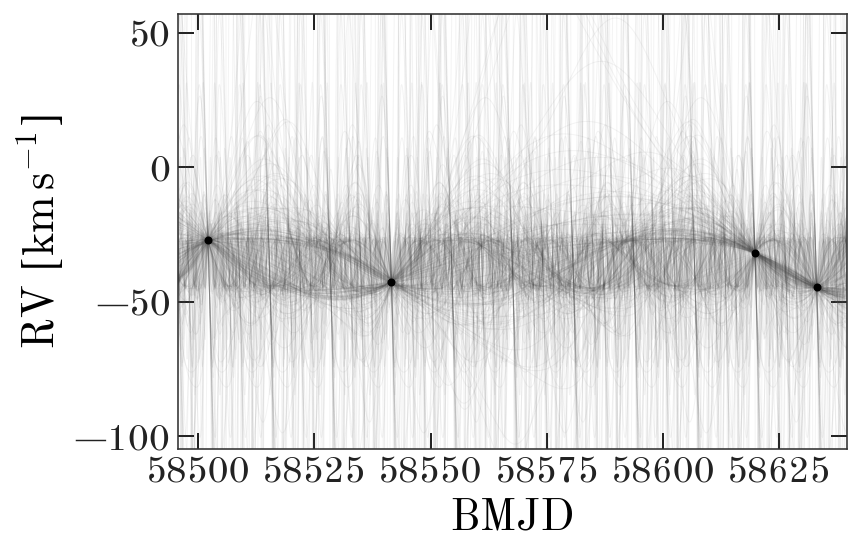

In [75]:
_ = plot_rv_curves(joker_samples, data=data)

It has various options to allow customizing the style of the plot:

Text(0.5, 0, 'BMJD$ - 58502.060$')

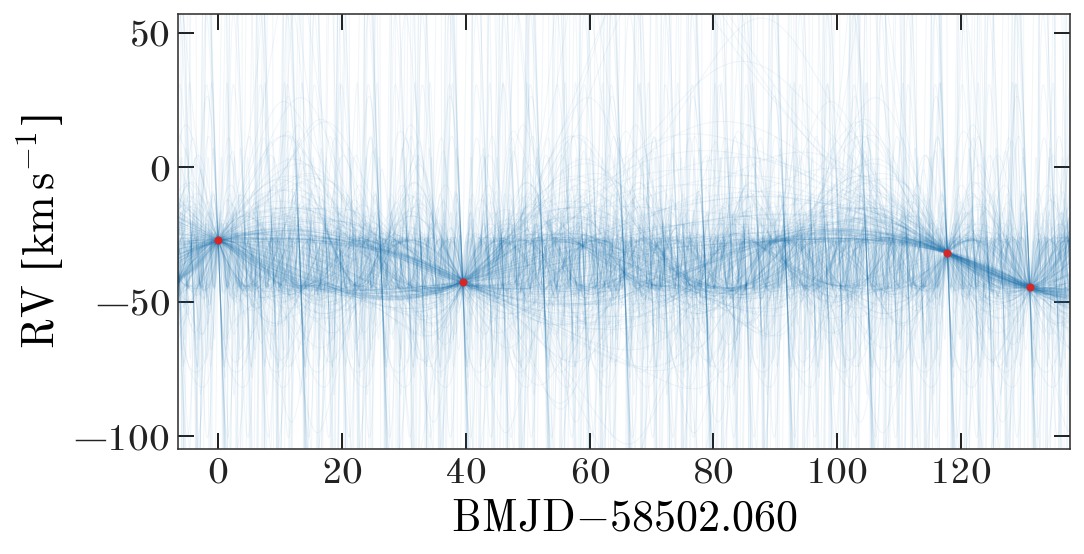

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = plot_rv_curves(joker_samples, data=data, 
                   plot_kwargs=dict(color='tab:blue'),
                   data_plot_kwargs=dict(color='tab:red'),
                   relative_to_t0=True, ax=ax)
ax.set_xlabel(f'BMJD$ - {data.t.tcb.mjd.min():.3f}$')

Another way to visualize the samples is to plot 2D projections of the sample values, for example, to plot period against eccentricity:

Text(0, 0.5, '$e$')

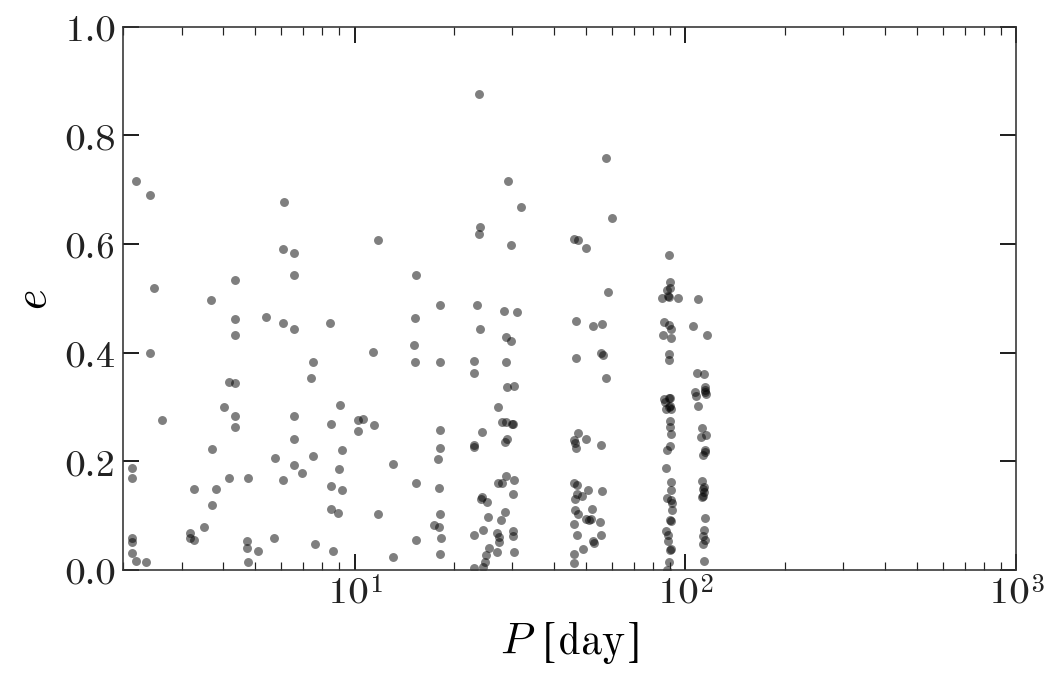

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.scatter(joker_samples['P'], 
               joker_samples['e'],
               s=20, lw=0, alpha=0.5)
        
ax.set_xscale('log')
ax.set_xlim(prior.pars['P'].distribution.a,
            prior.pars['P'].distribution.b)
ax.set_ylim(0, 1)

ax.set_xlabel('$P$ [day]')
ax.set_ylabel('$e$')

But is the true period value included in those distinct period modes returned by *The Joker*? When generating the simulated data, I also saved the true orbital parameters used to generate the data, so we can load and over-plot it:

In [86]:
import pickle
with open('true-orbit.pkl', 'rb') as f:
    elem = pickle.load(f)

Text(0, 0.5, '$e$')

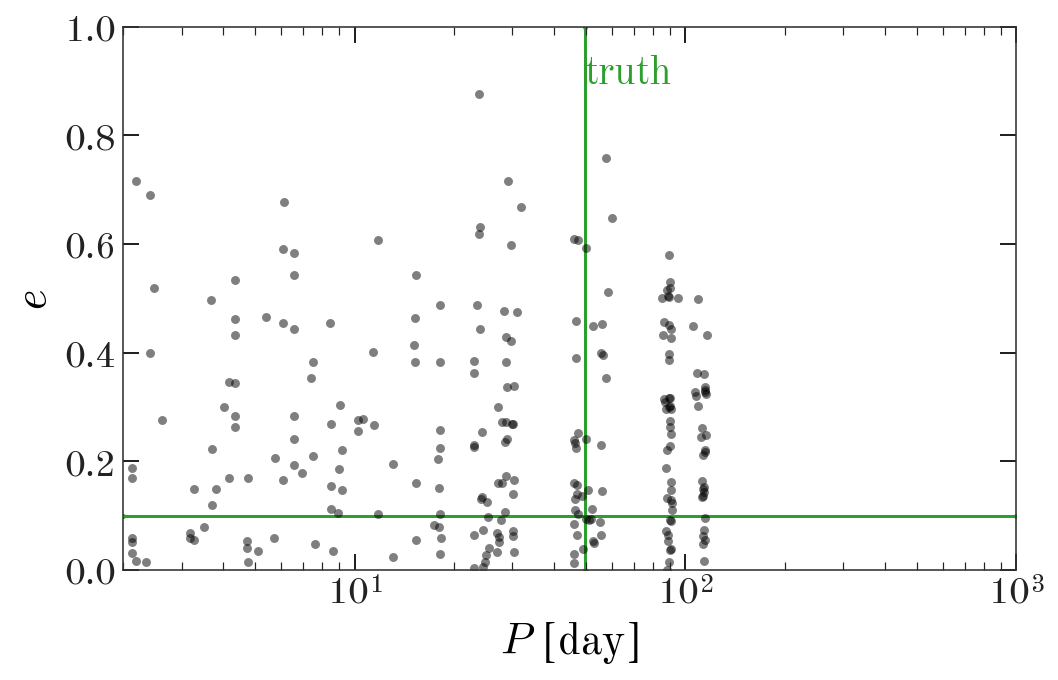

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with quantity_support():
    ax.scatter(joker_samples['P'], 
               joker_samples['e'],
               s=20, lw=0, alpha=0.5)
    
    ax.axvline(elem.P, zorder=-1, color='tab:green')
    ax.axhline(elem.e, zorder=-1, color='tab:green')
    ax.text(elem.P, 0.95, 'truth', fontsize=20, 
            va='top', ha='left', color='tab:green')
    
ax.set_xscale('log')
ax.set_xlim(prior.pars['P'].distribution.a,
            prior.pars['P'].distribution.b)
ax.set_ylim(0, 1)

ax.set_xlabel('$P$ [day]')
ax.set_ylabel('$e$')

It indeed looks like there are posterior samples from *The Joker* in the vicinity of the true value. Deciding what to do next depends on the problem you would like to solve. For example, if you just want to get a sense of how multi-modal the posterior *pdf* over orbital parameters is, you might be satisfied with the number of samples we generated and the plots we made in this tutorial. However, if you want to fully propagate the uncertainty in these orbital parameters through some other inference (for example, to transform the samples into constraints on companion mass or other properties), you may want or need to generate a lot more samples. To start, you could change ``max_posterior_samples`` to be a much larger number in the ``rejection_sample()`` step above. But I have found that in many cases, you need to run with many, many more (e.g., 500 million) prior samples. To read more, check out the next tutorial!